In [1]:
import pandas as pd

df = pd.read_csv("../data/final_experiment_dataset.csv")
final_experiment_df = df.copy()
final_experiment_df.head(5)

,client_id,Variation,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,merged_session_id,converted,first_time,last_time,total_duration_sec,n_events,n_attempts,n_errors,any_anomaly
0,9988021,Test,5.0,64.0,79.0,U,2.0,189023.86,1.0,4.0,1,False,2017-04-12 16:57:27,2017-04-17 15:27:07,426580.0,15,1,2,False
1,8320017,Test,22.0,274.0,34.5,M,2.0,36001.90,5.0,8.0,1,True,2017-04-05 13:08:06,2017-04-05 13:10:05,119.0,5,1,0,False
2,4033851,Control,12.0,149.0,63.5,M,2.0,142642.26,5.0,8.0,1,True,2017-04-05 12:04:00,2017-04-05 12:29:03,1503.0,15,1,3,True
3,1982004,Test,6.0,80.0,44.5,U,2.0,30231.76,1.0,4.0,1,True,2017-04-17 11:59:42,2017-04-17 12:02:42,180.0,5,1,0,False
4,9294070,Control,5.0,70.0,29.0,U,2.0,34254.54,0.0,3.0,1,False,2017-04-17 11:16:13,2017-04-17 11:16:28,15.0,2,1,0,False


In [2]:
final_experiment_df.shape

(56252, 19)

In [3]:
VANGUARD_PALETTE = {
    "red":      "#96151D",  # anchor
    "charcoal": "#222222",
    "slate":    "#4B5563",
    "steel":    "#64748B",
    "blue":     "#1F4E79",
    "teal":     "#0F766E",
    "gold":     "#B08900",
    "light":    "#E5E7EB",
}

# handy ordered list for seaborn/matplotlib
VANGUARD_COLORS = [
    VANGUARD_PALETTE["red"],
    VANGUARD_PALETTE["blue"],
    VANGUARD_PALETTE["teal"],
    VANGUARD_PALETTE["gold"],
    VANGUARD_PALETTE["slate"],
    VANGUARD_PALETTE["steel"],
    VANGUARD_PALETTE["charcoal"],
    VANGUARD_PALETTE["light"],
]

# Extra Hypothesis Number 1

“The new design improves conversion for high-friction sessions”

Some users struggle more than others (errors, retries). This hypothesis checks whether the redesign helps these users complete the process more often.

high-friction sessions are those with:
- at least one error (n_errors > 0) OR
- anomalous behavior (any_anomaly == True)

Hypothesis:
- H₀: For high-friction sessions, conversion is the same in Test and Control
- H₁: For high-friction sessions, conversion differs between Test and Control

In [4]:
import pandas as pd
from scipy.stats import chi2_contingency


df_high_friction = final_experiment_df[
    (final_experiment_df["n_errors"] > 0) |
    (final_experiment_df["any_anomaly"] == True)
]


conversion_rates = df_high_friction.groupby("Variation")["converted"].mean() * 100
print("Conversion rate for high-friction sessions (%):")
print(conversion_rates.round(2))


contingency_table = pd.crosstab(
    df_high_friction["Variation"],
    df_high_friction["converted"]
)

print("\nContingency table:")
print(contingency_table)

# Chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square statistic:", chi2)
print("p-value:", p_value)

Conversion rate for high-friction sessions (%):
Variation
Control    44.10
Test       49.91
Name: converted, dtype: float64

Contingency table:
converted  False  True 
Variation              
Control     4278   3375
Test        5095   5076

Chi-square statistic: 58.81525511840927
p-value: 1.7319325204871614e-14


Meaning:

- In the old design (Control), only 44.1% of struggling users completed the process
- In the new design (Test), 49.9% completed it

This is an improvement of ~5.8 percentage points which means among users who struggle, the new design helps noticeably more people finish the process.

The p-value is far below 0.05. This means the probability that this difference happened by chance is extremely low --> H₀ is rejected

There is a statistically significant difference in conversion rates between Test and Control for high-friction sessions.

Business Interpretation: The new design significantly improves conversion for users who struggle during the process.
This shows that the redesign reduces real usability friction rather than only helping users who already find the process easy.

# Extra Hypothesis Number 2

“The new design makes the experience more consistent (lower time variability)”

Even if average completion time is acceptable, large differences between users can indicate confusion. A consistent experience means users complete the process in similar amounts of time. This hypothesis tests whether the new design reduces extreme or inconsistent completion times. Lower variability suggests a clearer and more predictable user journey.

Hypotheses: 
- H₀: Completion time variability is the same for the Test and Control groups.
- H₁: Completion time variability differs between the Test and Control groups.

In [5]:
from scipy.stats import levene

# Use only completed sessions
df_completed = final_experiment_df[final_experiment_df["converted"] == True]

# Completion times by group
time_control = df_completed.loc[
    df_completed["Variation"] == "Control",
    "total_duration_sec"
].dropna()

time_test = df_completed.loc[
    df_completed["Variation"] == "Test",
    "total_duration_sec"
].dropna()

# Compare variability
print("Standard deviation (Control):", round(time_control.std(), 2))
print("Standard deviation (Test):", round(time_test.std(), 2))

# Levene's test for equality of variances # Levene’s test checks whether two groups have the same variability (spread). It does not compare averages, It answers whether one group more consistent than the other.
stat, p_value = levene(time_control, time_test, center="median")

print("Levene statistic:", stat)
print("p-value:", p_value)

Standard deviation (Control): 931300.26
Standard deviation (Test): 853872.61
Levene statistic: 4.035968054407481
p-value: 0.04454817928814427


This supports the idea of more consistency.
- The Test group has a lower standard deviation than the Control group.
- This means completion times in the new design are less spread out.
- the new design leads to a more consistent experience

The p-value is below 0.05. This means the difference in variability is statistically significant --> H₀ is rejected 
The difference in spread is not random.


The new design not only improves conversion, but also creates a more predictable and stable user experience. Fewer users get unusually stuck, which suggests clearer guidance and reduced confusion in the process.

In [8]:
# we work only for completed sessions
# Work on completed sessions only
df_completed = final_experiment_df[final_experiment_df["converted"]].copy()

q1 = df_completed["total_duration_sec"].quantile(0.25)
q3 = df_completed["total_duration_sec"].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df_viz = df_completed[
    (df_completed["total_duration_sec"] >= lower) &
    (df_completed["total_duration_sec"] <= upper)
].copy()

df_viz["total_duration_min"] = df_viz["total_duration_sec"] / 60


/var/folders/13/s00136yd6q5bvv6x74_x_m204g4004/T/ipykernel_88776/2865837875.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


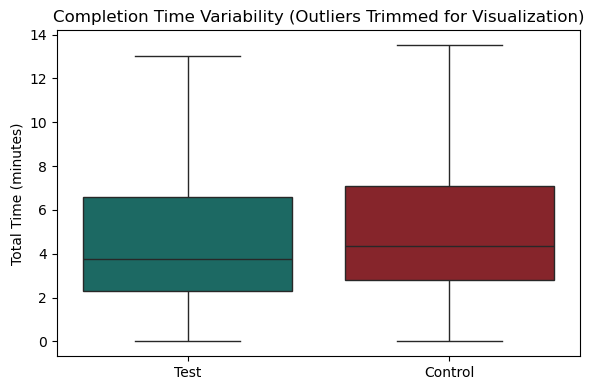

In [9]:
# plotting a boxplot visualization for the results above
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_viz,
    x="Variation",
    y="total_duration_min",
    palette=[VANGUARD_PALETTE["teal"], VANGUARD_PALETTE["red"]],
    showfliers=False
)

plt.title("Completion Time Variability (Outliers Trimmed for Visualization)")
plt.xlabel("")
plt.ylabel("Total Time (minutes)")
plt.tight_layout()
plt.show()




Extreme completion times were excluded from visualizations for clarity. Variability tests were conducted on the full dataset using robust methods. 